In [1]:
import pandas as pd
import mysql
from connect import DatabaseConnector
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Total Views : from the Vendor Views logs Table We use the vendor_id to count the number views made

In [38]:
def get_vendor_Total_Views(vendor_id):
    
    db_connector = DatabaseConnector()  # Create an instance of DatabaseConnector
    # Connect to the database
    db_connector.connect_db()
    # Get the database connection
    connection = db_connector.get_connection()

    # If connection is not established, return
    if connection is None:
        print("No connection available to summarize the database.")
        return
    cursor = connection.cursor()

    try:
        # Execute the query to calculate the total count of the specified vendor_id
        query = f"""
            SELECT COUNT(*) AS count
            FROM vendor_view_logs
            WHERE vendor_id = %s
        """
        cursor.execute(query, (vendor_id,))
        result = cursor.fetchone()

        if result:
            return result[0]  # Extract count from the result tuple
        else:
            return 0  # If no rows are found, return count as 0
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

In [40]:
get_vendor_Total_Views(266)

Successfully connected to the database
Connection closed


637

In [5]:
def plot_vendor_comparison(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve vendor counts.")
        return

    cursor = connection.cursor()

    try:
        # Get count for the specified vendor_id and all vendors
        query = """
            SELECT vendor_id, COUNT(*) AS total_views
            FROM vendor_view_logs
            GROUP BY vendor_id
        """
        cursor.execute(query)
        results = cursor.fetchall()

        # Create a DataFrame from the results
        df = pd.DataFrame(results, columns=['vendor_id', 'total_views'])

        # Get count for the specified vendor_id
        specified_vendor_count = df[df['vendor_id'] == vendor_id]['total_views'].values[0]

        # Get the vendor_id with the highest count
        highest_vendor_count = df['total_views'].max()

        # Get ranks
        df['rank'] = df['total_views'].rank(method='min', ascending=False)
        specified_vendor_rank = df[df['vendor_id'] == vendor_id]['rank'].values[0]
        highest_vendor_rank = df[df['total_views'] == highest_vendor_count]['rank'].values[0]

        # Plotting
        plt.figure(figsize=(8, 6))
        bars = plt.bar(['Specified Vendor', 'Highest Vendor'], [specified_vendor_count, highest_vendor_count], color=['skyblue', 'orange'])
        plt.xlabel('Vendor')
        plt.ylabel('Total Views')
        plt.title('Comparison of Specified Vendor vs Highest Vendor')

        # Add rank numbers at the top of each bar
        plt.text(bars[0].get_x() + bars[0].get_width() / 2, bars[0].get_height(), f'Rank: {int(specified_vendor_rank)}', ha='center', va='bottom')
        plt.text(bars[1].get_x() + bars[1].get_width() / 2, bars[1].get_height(), f'Rank: {int(highest_vendor_rank)}', ha='center', va='bottom')

        plt.show()
    except mysql.connector.Error as e:
        print(f"Error: {e}")
    finally:
        cursor.close()
        db_connector.close_connection()

# We can ranke our vendor produt views with the highest views

Successfully connected to the database


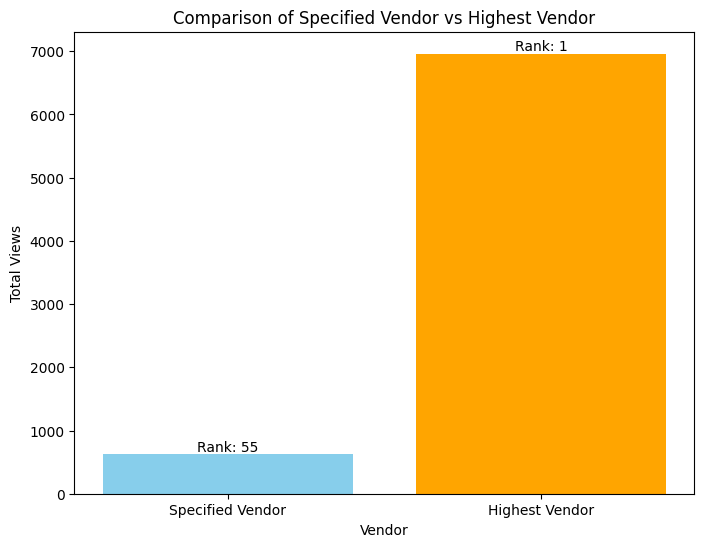

Connection closed


In [6]:
plot_vendor_comparison(268)

In [7]:
def is_vendor(user_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to check user type.")
        return False

    cursor = connection.cursor()

    try:
        # Query to check if the user is a vendor
        query = """
            SELECT type
            FROM users
            WHERE id = %s
        """
        cursor.execute(query, (user_id,))
        result = cursor.fetchone()

        if result and result[0] == 'vendor':
            return True
        else:
            return False
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return False
    finally:
        cursor.close()
        db_connector.close_connection()


# Example usage
user_id = 123  # Replace with the actual user ID
is_vendor_user = is_vendor(user_id)
print(f"Is the user with ID {user_id} a vendor? {is_vendor_user}")

Successfully connected to the database
Connection closed
Is the user with ID 123 a vendor? True


In [8]:
# Example usage
user_id = 26  # Replace with the actual user ID
is_vendor_user = is_vendor(user_id)
print(f"Is the user with ID {user_id} a vendor? {is_vendor_user}")

Successfully connected to the database
Connection closed
Is the user with ID 26 a vendor? True


# 2. Unique Customers Count based on the buy_logs, Products, and Vendor table

In [9]:
def get_unique_customers_count(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve unique customers count.")
        return None

    cursor = connection.cursor()

    try:
        # Query to get the number of unique customer_id for a given vendor_id
        query = """
            SELECT COUNT(DISTINCT buy_logs.user_id) AS unique_customers_count
            FROM vendors
            JOIN products ON vendors.user_id = products.user_id
            JOIN buy_logs ON products.id = buy_logs.product_id
            WHERE vendors.user_id = %s
        """
        cursor.execute(query, (vendor_id,))
        result = cursor.fetchone()

        if result:
            return result[0]  # Extract unique_customers_count from the result tuple
        else:
            return 0  # If no rows are found, return 0
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

In [10]:
# Example usage
vendor_id = 26  # Replace with the actual vendor ID
unique_customers_count = get_unique_customers_count(vendor_id)
print(f"Number of unique customers for vendor ID {vendor_id}: {unique_customers_count}")

Successfully connected to the database
Connection closed
Number of unique customers for vendor ID 26: 274


# 2.1 Optimized Unique Costomers Count based on the buy_logs, Products, and Vendor table

In [11]:
def get_unique_customers_count(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve unique customers count.")
        return None

    cursor = connection.cursor()

    try:
        # Nested query to get the number of unique customer_id for a given vendor_id
        query = """
            SELECT COUNT(DISTINCT user_id) AS unique_customers_count
            FROM buy_logs
            WHERE product_id IN (
                SELECT id
                FROM products
                WHERE user_id = (
                    SELECT user_id
                    FROM vendors
                    WHERE user_id = %s
                )
            )
        """
        cursor.execute(query, (vendor_id,))
        result = cursor.fetchone()

        if result:
            return result[0]  # Extract unique_customers_count from the result tuple
        else:
            return 0  # If no rows are found, return 0
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()


In [12]:

# Example usage
vendor_id = 268  # Replace with the actual vendor ID
unique_customers_count = get_unique_customers_count(vendor_id)
print(f"Number of unique customers for vendor ID {vendor_id}: {unique_customers_count}")

Successfully connected to the database
Connection closed
Number of unique customers for vendor ID 268: 15


# 3. Number views Per Products  making use of View_product_logs

In [13]:
def get_product_views_count(product_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve product views count.")
        return None

    cursor = connection.cursor()

    try:
        # Query to get the number of views for the given product_id
        query = """
            SELECT COUNT(*) AS views_count
            FROM product_view_logs
            WHERE product_id = %s
        """
        cursor.execute(query, (product_id,))
        result = cursor.fetchone()

        if result:
            return result[0]  # Extract views_count from the result tuple
        else:
            return 0  # If no rows are found, return 0
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

In [14]:
# Example usage
product_id = 1  # Replace with the actual product ID
views_count = get_product_views_count(product_id)
print(f"Number of views for product ID {product_id}: {views_count}")

Successfully connected to the database
Connection closed
Number of views for product ID 1: 20


In [15]:
def get_vendor_product_views(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve product views count.")
        return None

    cursor = connection.cursor()

    try:
        # Step 1: Get all product IDs for the given vendor_id
        product_query = """
            SELECT id
            FROM products
            WHERE user_id = %s
        """
        cursor.execute(product_query, (vendor_id,))
        product_ids = cursor.fetchall()

        if not product_ids:
            print(f"No products found for vendor_id {vendor_id}")
            return None

        # Convert product_ids to a list
        product_ids = [product_id[0] for product_id in product_ids]

        # Step 2: Get the count of views for each product_id in the list using a single query
        format_ids = ','.join(map(str, product_ids))
        view_count_query = f"""
            SELECT product_id, COUNT(*) AS product_id_count
            FROM product_view_logs
            WHERE product_id IN ({format_ids})
            GROUP BY product_id
        """
        cursor.execute(view_count_query)
        view_counts = cursor.fetchall()

        # Create a dictionary from the view counts
        view_count_dict = {product_id: count for product_id, count in view_counts}

        # Step 3: Prepare the final data with all product_ids and their counts
        product_view_counts = [(product_id, view_count_dict.get(product_id, 0)) for product_id in product_ids]

        # Step 4: Create the DataFrame
        df_vendor_product_views = pd.DataFrame(product_view_counts, columns=['product_id', 'product_id_count'])

        return df_vendor_product_views
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

In [16]:
# Example usage
vendor_id = 266  # Replace with the actual vendor ID
df_vendor_product_views = get_vendor_product_views(vendor_id)
print(df_vendor_product_views)

Successfully connected to the database
Connection closed
    product_id  product_id_count
0          605               142
1          606               382
2          607               167
3         1272                66
4         1273                28
5         1274                20
6         1275                22
7         1276                22
8         1277                32
9         1278                28
10        1279                29
11        1280                94
12        1281                81
13       18743                 0
14       18744                 0
15       18745                 0
16       18746                 0
17       18747                 0
18       18748                 0
19       18749                 0
20       18750                 2
21       18751                 0
22       18752                 0
23       18753                 0
24       18754                 0
25       18905                 0
26       18906                 0
27       18907     

In [17]:
def get_vendor_product_views_and_plot(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to retrieve product views count.")
        return None

    cursor = connection.cursor()

    try:
        # Step 1: Get all product IDs and names for the given vendor_id
        product_query = """
            SELECT id, name
            FROM products
            WHERE user_id = %s
        """
        cursor.execute(product_query, (vendor_id,))
        products = cursor.fetchall()

        if not products:
            print(f"No products found for vendor_id {vendor_id}")
            return None

        # Convert products to a list of tuples
        product_data = [(product_id, product_name) for product_id, product_name in products]
        product_ids = [product_id for product_id, _ in products]

        # Step 2: Get the count of views for each product_id in the list using a single query
        format_ids = ','.join(map(str, product_ids))
        view_count_query = f"""
            SELECT product_id, COUNT(*) AS product_id_count
            FROM product_view_logs
            WHERE product_id IN ({format_ids})
            GROUP BY product_id
        """
        cursor.execute(view_count_query)
        view_counts = cursor.fetchall()

        # Create a dictionary from the view counts
        view_count_dict = {product_id: count for product_id, count in view_counts}

        # Step 3: Prepare the final data with all product_ids, their names, and their counts
        product_view_counts = [(product_id, product_name, view_count_dict.get(product_id, 0)) for product_id, product_name in product_data]

        # Step 4: Create the DataFrame
        df_vendor_product_views = pd.DataFrame(product_view_counts, columns=['product_id', 'product_name', 'product_id_count'])

        return df_vendor_product_views
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

def plot_dataframe(df):
    if df is not None and not df.empty:
        plt.figure(figsize=(14, 8))  # Increase the figure size
        plt.bar(df['product_name'], df['product_id_count'], color='blue')
        plt.xlabel('Product Name')
        plt.ylabel('View Count')
        plt.title(f'Product View Counts')
        plt.xticks(rotation=90)
        
        # Manually adjust the subplot parameters to give more room for the labels
        plt.subplots_adjust(bottom=0.3)  # Adjust the bottom margin
        
        plt.show()
    else:
        print("The DataFrame is empty or None.")

Successfully connected to the database
Connection closed


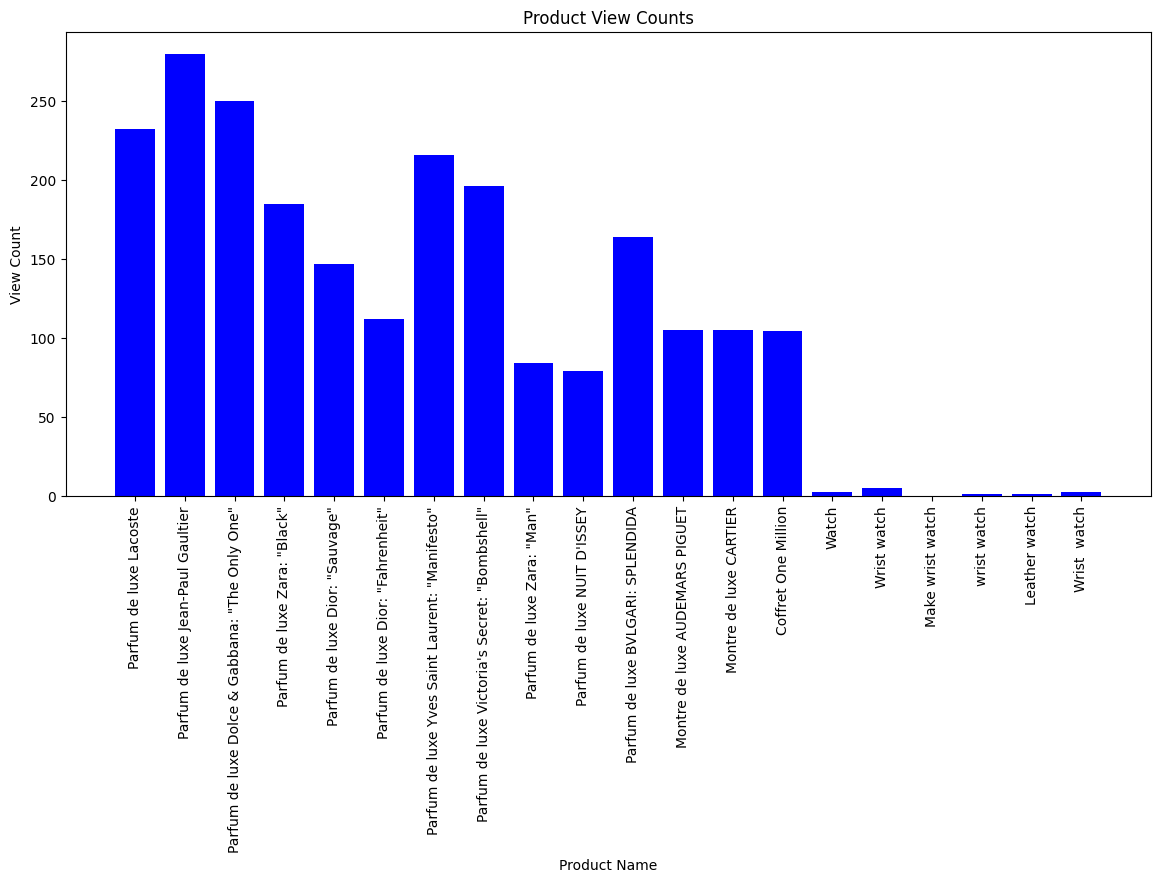

    product_id                                    product_name  \
0          468                          Parfum de luxe Lacoste   
1          469               Parfum de luxe Jean-Paul Gaultier   
2          474  Parfum de luxe Dolce & Gabbana: "The Only One"   
3          475                    Parfum de luxe Zara: "Black"   
4          476                  Parfum de luxe Dior: "Sauvage"   
5          478               Parfum de luxe Dior: "Fahrenheit"   
6          494  Parfum de luxe Yves Saint Laurent: "Manifesto"   
7          496   Parfum de luxe Victoria's Secret: "Bombshell"   
8          499                      Parfum de luxe Zara: "Man"   
9          504                     Parfum de luxe NUIT D'ISSEY   
10         506               Parfum de luxe BVLGARI: SPLENDIDA   
11         511                  Montre de luxe AUDEMARS PIGUET   
12         619                          Montre de luxe CARTIER   
13         620                          Montre de luxe CARTIER   
14        

In [18]:
# Example usage
vendor_id = 268  # Replace with the actual vendor ID
df_vendor_product_views = get_vendor_product_views_and_plot(vendor_id)
plot_dataframe(df_vendor_product_views)
print(df_vendor_product_views)

# Views Per Catigoury

In [31]:
def get_customer_category_views_count(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to summarize the database.")
        return None

    try:
        query = """
        SELECT c.id AS category_id, c.name AS category_name, COUNT(cvl.id) AS views_count
        FROM categories c
        JOIN (
            SELECT p.category_id
            FROM products p
            JOIN vendors v ON p.user_id = v.user_id
            WHERE v.user_id = %s
            GROUP BY p.category_id
        ) AS vendor_categories ON c.id = vendor_categories.category_id
        LEFT JOIN category_view_logs cvl ON c.id = cvl.category_id
        GROUP BY c.id, c.name
        """

        df = pd.read_sql(query, connection, params=(vendor_id,))
        return df
    except mysql.connector.Error as e:
        print(f"Error: {e}")
        return None
    finally:
        db_connector.close_connection()

In [41]:

# Example usage
vendor_id = 268  # Replace with the actual vendor ID
df_customer_category_views_count = get_customer_category_views_count(vendor_id)
print(df_customer_category_views_count)

Successfully connected to the database


/tmp/ipykernel_39155/2648682037.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Connection closed
   category_id     category_name  views_count
0          137  Women Fragrances          395
1          138    Men Fragrances          281
2          251           Jewelry           53
3          264     Men's Watches          202


In [2]:
def get_customer_category_views_count(vendor_id):
    
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to summarize the database.")
        return None

    try:
        # Subquery to get all category IDs for the provided vendor_id
        subquery = f"""
        SELECT DISTINCT category_id
        FROM products
        WHERE user_id = (SELECT user_id FROM vendors WHERE user_id = {vendor_id})
        """

        # Main query to count views for each category
        query = f"""
        SELECT c.id AS category_id, c.name AS category_name, 
        (SELECT COUNT(*) FROM category_view_logs cvl WHERE cvl.category_id = c.id) AS views_count
        FROM categories c
        WHERE c.id IN ({subquery})
        """

        df = pd.read_sql(query, connection)
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None
    finally:
        db_connector.close_connection()

In [3]:
# Example usage
vendor_id = 268  # Replace with the actual vendor ID
df_customer_category_views_count = get_customer_category_views_count(vendor_id)
print(df_customer_category_views_count)

Successfully connected to the database


/tmp/ipykernel_42593/2648682037.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Connection closed
   category_id     category_name  views_count
0          137  Women Fragrances          395
1          138    Men Fragrances          281
2          251           Jewelry           53
3          264     Men's Watches          202


In [4]:
def plot_category_views(df):
    # Get the DataFrame with category view counts

    if df is None or df.empty:
        print("No data available to plot.")
        return

    # Plotting the bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(x='category_name', y='views_count', data=df, palette='viridis')

    # Adding titles and labels
    plt.title('Category Views Count for Vendor')
    plt.xlabel('Category Name')
    plt.ylabel('Views Count')
    
    # Rotate category names for better readability
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

/tmp/ipykernel_42593/2659581016.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category_name', y='views_count', data=df, palette='viridis')


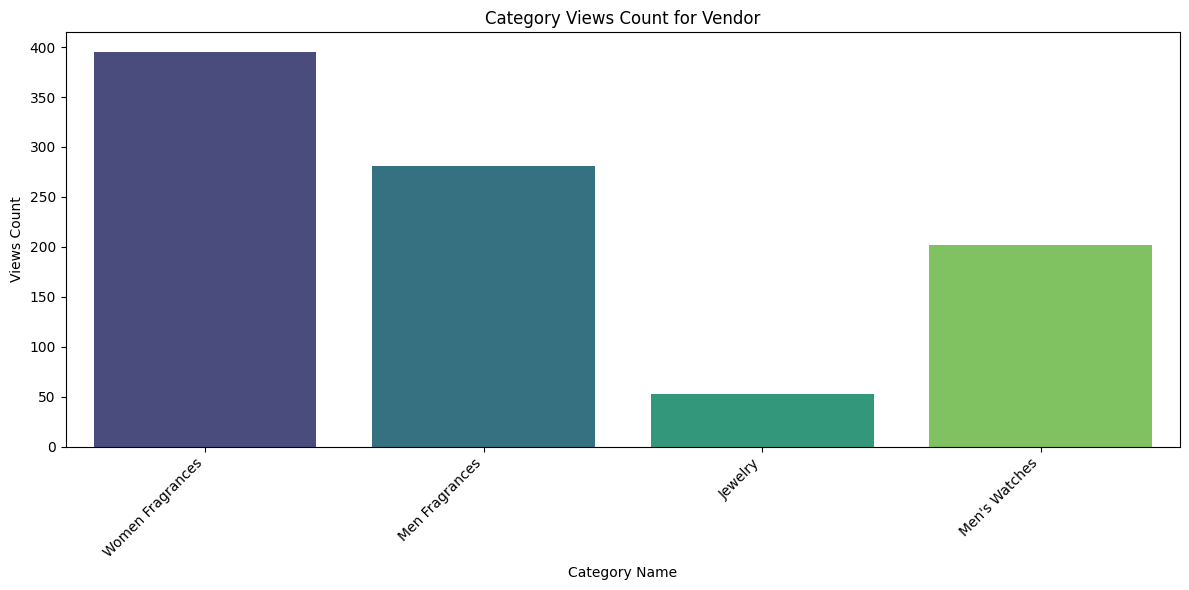

In [5]:
plot_category_views(df_customer_category_views_count)

In [8]:
def get_user_view_count(user_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to get the view count.")
        return None

    try:
        query = """
        SELECT COUNT(*) AS view_count
        FROM product_view_logs
        WHERE user_id = %s
        """
        
        # Use SQLAlchemy engine to execute the query
        df = pd.read_sql(query, connection, params=(user_id,))
        
        # Return the view count from the DataFrame
        return df['view_count'].iloc[0] if not df.empty else 0
    except Exception as e:
        print(f"Error: {e}")
        return None
    finally:
        db_connector.close_connection()

In [11]:
# Example usage
user_id = 292  # Replace with the actual user ID
view_count = get_user_view_count(user_id)
print(f"User {user_id} has {view_count} views.")

Successfully connected to the database


/tmp/ipykernel_39863/2386561411.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection, params=(user_id,))


Connection closed
User 292 has 194 views.


Successfully connected to the database
Connection closed
      month  view_count
0   2021-10           1
1   2021-11         309
2   2021-12         633
3   2022-01          41
4   2022-02          10
5   2022-03           6
6   2022-04          16
7   2022-05          15
8   2022-06          14
9   2022-07          12
10  2022-08          16
11  2022-09           5
12  2022-10           3
13  2022-11           2
14  2023-01           8
15  2023-02           4
16  2023-03           2
17  2023-04           2
18  2023-05           3
19  2023-06           2
20  2023-07           8
21  2024-01           1
22  2024-02           3
23  2024-03           2


/tmp/ipykernel_6284/760471012.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='view_count', data=df, palette='viridis')


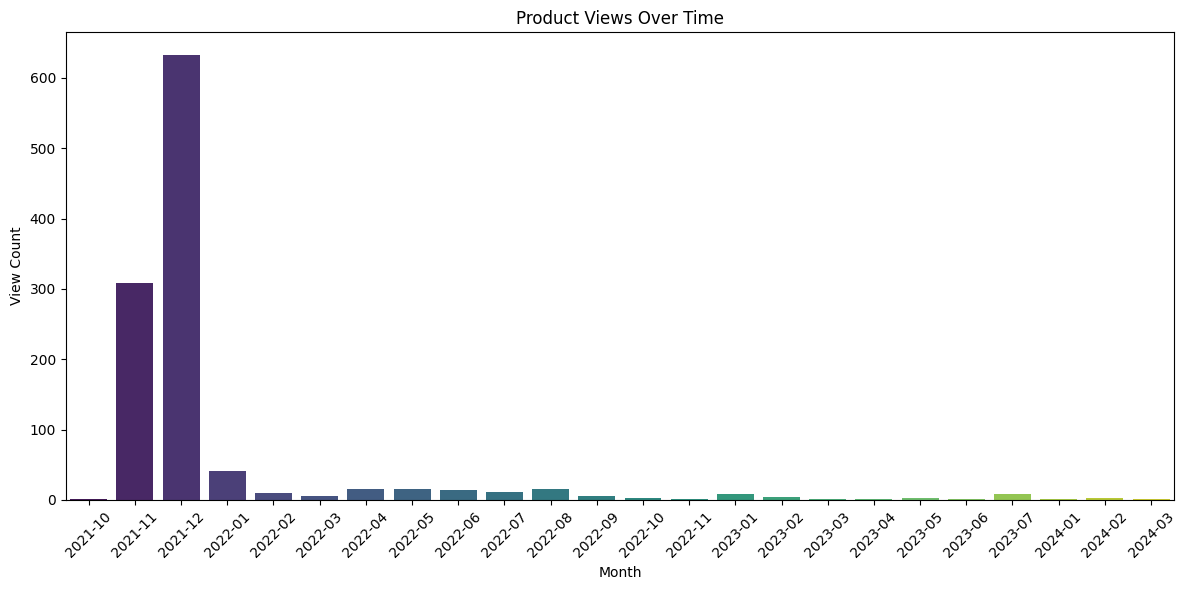

In [22]:
import pandas as pd
from connect import DatabaseConnector

def get_product_views_over_time(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to get the view count.")
        return None

    try:
        query = """
        SELECT 
            DATE_FORMAT(pvl.created_at, '%Y-%m') AS month,
            COUNT(pvl.id) AS view_count
        FROM 
            product_view_logs pvl
        JOIN 
            products p ON p.id = pvl.product_id
        WHERE 
            p.user_id = %s
        GROUP BY 
            DATE_FORMAT(pvl.created_at, '%Y-%m')
        ORDER BY 
            month
        """
        
        # Execute the query
        cursor = connection.cursor(dictionary=True)
        cursor.execute(query, (vendor_id,))
        result = cursor.fetchall()
        
        # Convert the result to a DataFrame
        df = pd.DataFrame(result)
        
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

def plot_views_over_time(df):

    # Plotting the data
    plt.figure(figsize=(12, 6))
    sns.barplot(x='month', y='view_count', data=df, palette='viridis')
    plt.title('Product Views Over Time')
    plt.xlabel('Month')
    plt.ylabel('View Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
vendor_id = 266  # Replace with the actual vendor ID
df_views_over_time = get_product_views_over_time(vendor_id)
if df_views_over_time is not None:
    print(df_views_over_time)
    plot_views_over_time(df_views_over_time)


In [20]:

# Example usage
vendor_id = 266  # Replace with the actual vendor ID
df_views_over_time = get_product_views_over_time(vendor_id)
if df_views_over_time is not None:
    print(df_views_over_time)
    plot_views_over_time(df_views_over_time)

Successfully connected to the database
Error: Query must be a string unless using sqlalchemy.
Connection closed


/tmp/ipykernel_6284/3464421625.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(text(query), connection, params={'vendor_id': vendor_id})


In [23]:
def get_product_views_over_time(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to get the view count.")
        return None

    try:
        query = """
        SELECT 
            DATE_FORMAT(pvl.created_at, '%Y-%m') AS month,
            YEAR(pvl.created_at) AS year,
            COUNT(pvl.id) AS view_count
        FROM 
            product_view_logs pvl
        JOIN 
            products p ON p.id = pvl.product_id
        WHERE 
            p.user_id = %s AND pvl.created_at >= DATE_SUB(CURDATE(), INTERVAL 3 YEAR)
        GROUP BY 
            YEAR(pvl.created_at), DATE_FORMAT(pvl.created_at, '%Y-%m')
        ORDER BY 
            year, month
        """
        
        # Execute the query
        cursor = connection.cursor(dictionary=True)
        cursor.execute(query, (vendor_id,))
        result = cursor.fetchall()
        
        # Convert the result to a DataFrame
        df = pd.DataFrame(result)
        
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

def plot_views_over_time(df):
    import matplotlib.pyplot as plt
    import seaborn as sns

    df['month'] = pd.to_datetime(df['month'])
    df['month'] = df['month'].dt.strftime('%Y-%m')

    # Plotting the data
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='month', y='view_count', hue='year', data=df, marker='o')
    plt.title('Product Views Over Time by Year')
    plt.xlabel('Month')
    plt.ylabel('View Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title='Year')
    plt.show()

Successfully connected to the database
Connection closed
      month  year  view_count
0   2021-10  2021           1
1   2021-11  2021         309
2   2021-12  2021         633
3   2022-01  2022          41
4   2022-02  2022          10
5   2022-03  2022           6
6   2022-04  2022          16
7   2022-05  2022          15
8   2022-06  2022          14
9   2022-07  2022          12
10  2022-08  2022          16
11  2022-09  2022           5
12  2022-10  2022           3
13  2022-11  2022           2
14  2023-01  2023           8
15  2023-02  2023           4
16  2023-03  2023           2
17  2023-04  2023           2
18  2023-05  2023           3
19  2023-06  2023           2
20  2023-07  2023           8
21  2024-01  2024           1
22  2024-02  2024           3
23  2024-03  2024           2


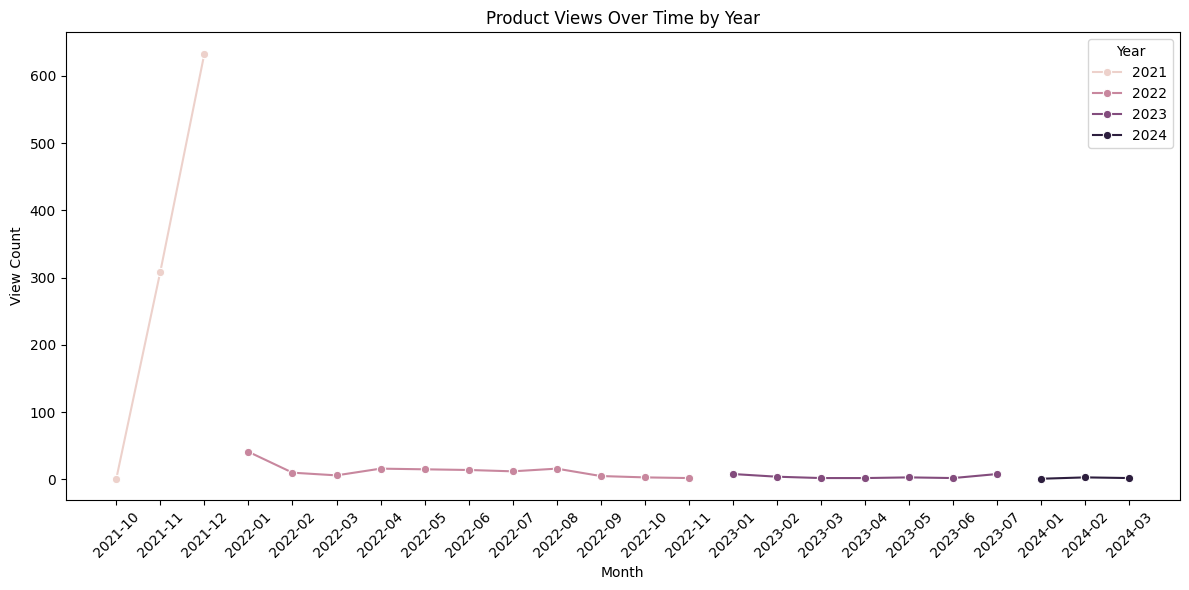

In [24]:
# Example usage
vendor_id = 266  # Replace with the actual vendor ID
df_views_over_time = get_product_views_over_time(vendor_id)
if df_views_over_time is not None:
    print(df_views_over_time)
    plot_views_over_time(df_views_over_time)

Successfully connected to the database
Connection closed
                                   product_name    month  year  view_count
0   Abonnement PlayStation Plus 1 mois – France  2021-12  2021          17
1   Abonnement PlayStation Plus 1 mois – France  2022-01  2022           2
2   Abonnement PlayStation Plus 1 mois – France  2022-03  2022           1
3   Abonnement PlayStation Plus 1 mois – France  2022-05  2022           1
4   Abonnement PlayStation Plus 1 mois – France  2023-01  2023           1
..                                          ...      ...   ...         ...
94                     Samsung Galaxy S9 SImple  2022-02  2022           1
95                     Samsung Galaxy S9 SImple  2022-04  2022           2
96                     Samsung Galaxy S9 SImple  2022-06  2022           1
97                     Samsung Galaxy S9 SImple  2022-07  2022           1
98                     Samsung Galaxy S9 SImple  2022-10  2022           1

[99 rows x 4 columns]


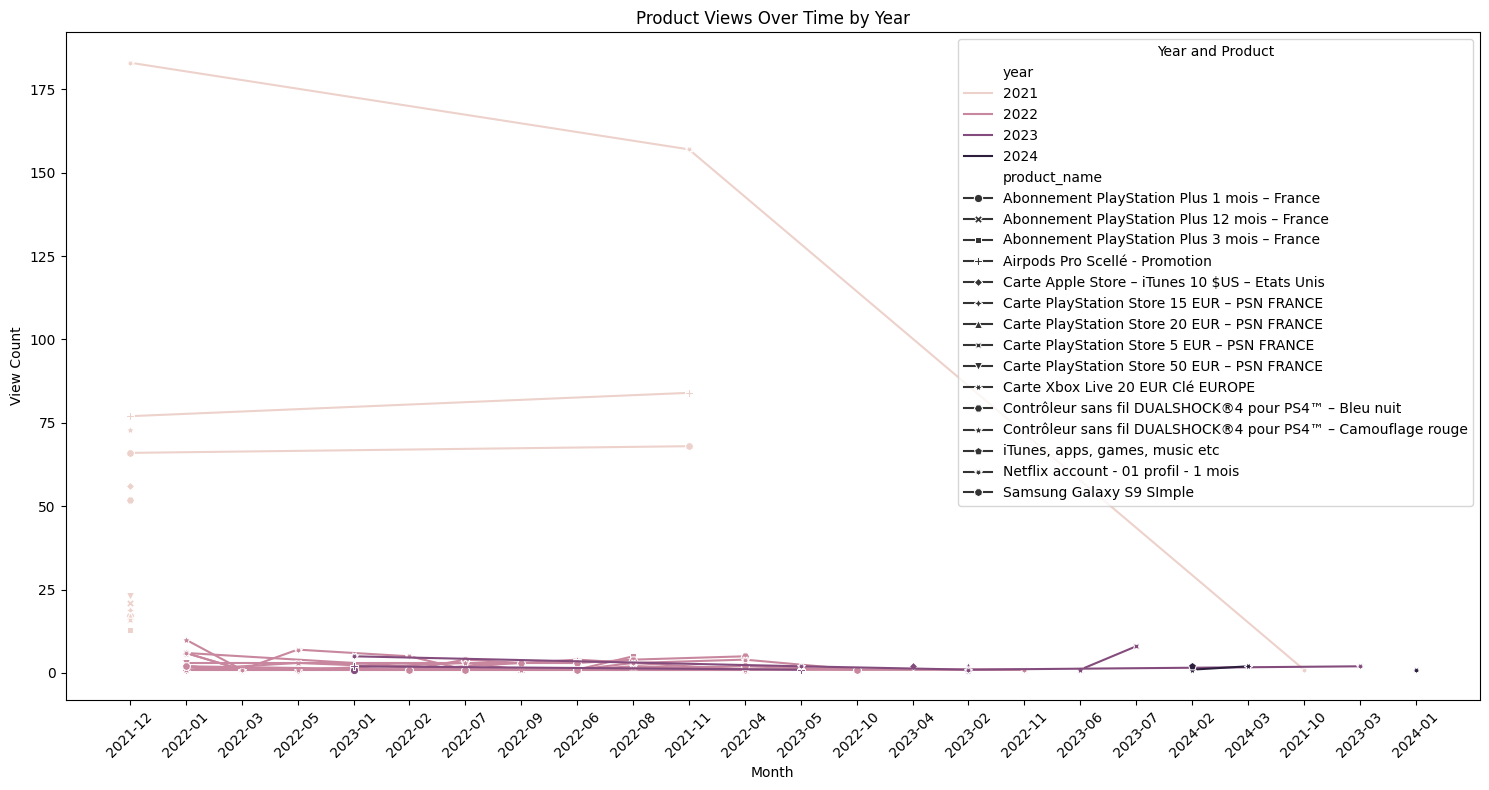

In [25]:
def get_product_views_over_time(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to get the view count.")
        return None

    try:
        query = """
        SELECT 
            p.name AS product_name,
            DATE_FORMAT(pvl.created_at, '%Y-%m') AS month,
            YEAR(pvl.created_at) AS year,
            COUNT(pvl.id) AS view_count
        FROM 
            product_view_logs pvl
        JOIN 
            products p ON p.id = pvl.product_id
        WHERE 
            p.user_id = %s AND pvl.created_at >= DATE_SUB(CURDATE(), INTERVAL 3 YEAR)
        GROUP BY 
            p.name, YEAR(pvl.created_at), DATE_FORMAT(pvl.created_at, '%Y-%m')
        ORDER BY 
            p.name, year, month
        """
        
        # Execute the query
        cursor = connection.cursor(dictionary=True)
        cursor.execute(query, (vendor_id,))
        result = cursor.fetchall()
        
        # Convert the result to a DataFrame
        df = pd.DataFrame(result)
        
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

def plot_views_over_time(df):
    df['month'] = pd.to_datetime(df['month'])
    df['month'] = df['month'].dt.strftime('%Y-%m')

    # Plotting the data
    plt.figure(figsize=(15, 8))
    sns.lineplot(x='month', y='view_count', hue='year', style='product_name', data=df, markers=True, dashes=False)
    plt.title('Product Views Over Time by Year')
    plt.xlabel('Month')
    plt.ylabel('View Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title='Year and Product')
    plt.show()

# Example usage
vendor_id = 266  # Replace with the actual vendor ID
df_views_over_time = get_product_views_over_time(vendor_id)
if df_views_over_time is not None:
    print(df_views_over_time)
    plot_views_over_time(df_views_over_time)


In [10]:
def get_user_product_views(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to get the view count.")
        return None

    try:
        query = """
        SELECT 
            p.id AS product_id,
            p.name AS product_name,
            pvl.user_id,
            COUNT(pvl.id) AS view_count
        FROM 
            product_view_logs pvl
        JOIN 
            products p ON p.id = pvl.product_id
        WHERE 
            p.user_id = %s
        GROUP BY 
            p.id, p.name, pvl.user_id
        ORDER BY 
            p.id, pvl.user_id
        """
        
        # Execute the query
        cursor = connection.cursor()
        cursor.execute(query, (vendor_id,))
        rows = cursor.fetchall()
        
        # Create a DataFrame
        df = pd.DataFrame(rows, columns=['product_id', 'product_name', 'user_id', 'view_count'])
        
        return df
    except Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

In [12]:
# Example usage
vendor_id = 268  # Replace with the actual vendor ID
df_user_product_views = get_user_product_views(vendor_id)
if df_user_product_views is not None:
    print(df_user_product_views)

Successfully connected to the database
Connection closed
     product_id            product_name  user_id  view_count
0           468  Parfum de luxe Lacoste        0           4
1           468  Parfum de luxe Lacoste      115           6
2           468  Parfum de luxe Lacoste      292           4
3           468  Parfum de luxe Lacoste     1655           4
4           468  Parfum de luxe Lacoste     1661           5
..          ...                     ...      ...         ...
461        2064             Wrist watch     2783           1
462        2064             Wrist watch     4360           3
463        2064             Wrist watch     7482           1
464        2065            Wrist  watch     4360           1
465        2065            Wrist  watch     8051           1

[466 rows x 4 columns]


In [15]:
def get_views_by_location(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to get the view count.")
        return None

    try:
        query = """
        SELECT 
            pvl.user_lat AS latitude,
            pvl.user_long AS longitude,
            COUNT(pvl.id) AS view_count
        FROM 
            product_view_logs pvl
        JOIN 
            products p ON p.id = pvl.product_id
        WHERE 
            p.user_id = %s
        GROUP BY 
            pvl.user_lat, pvl.user_long
        ORDER BY 
            view_count DESC
        """
        
        # Execute the query
        cursor = connection.cursor()
        cursor.execute(query, (vendor_id,))
        rows = cursor.fetchall()
        
        # Create a DataFrame
        df = pd.DataFrame(rows, columns=['latitude', 'longitude', 'view_count'])
        
        return df
    except Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

In [16]:
# Example usage
vendor_id = 268  # Replace with the actual vendor ID
df_views_by_location = get_views_by_location(vendor_id)
if df_views_by_location is not None:
    print(df_views_by_location)


Successfully connected to the database
Connection closed
     latitude  longitude  view_count
0    0.000000   0.000000         813
1         NaN        NaN         287
2    3.853390  11.486984         283
3    3.879746  11.478107          60
4    4.164829   9.241319          45
..        ...        ...         ...
139  3.832735  11.494843           1
140  4.161263   9.302296           1
141  3.878818  11.484076           1
142  4.153900   9.256559           1
143  4.045136   9.693161           1

[144 rows x 3 columns]


In [17]:
def get_views_by_location(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to get the view count.")
        return None

    try:
        query = """
        SELECT 
            pvl.user_lat AS latitude,
            pvl.user_long AS longitude,
            COUNT(pvl.id) AS view_count
        FROM 
            product_view_logs pvl
        JOIN 
            products p ON p.id = pvl.product_id
        JOIN
            vendors v ON v.user_id = p.user_id
        WHERE 
            v.user_id = %s
        GROUP BY 
            pvl.user_lat, pvl.user_long
        ORDER BY 
            view_count DESC
        """
        
        # Execute the query
        cursor = connection.cursor()
        cursor.execute(query, (vendor_id,))
        rows = cursor.fetchall()
        
        # Create a DataFrame
        df = pd.DataFrame(rows, columns=['latitude', 'longitude', 'view_count'])
        
        return df
    except Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()
        db_connector.close_connection()

In [19]:
# Example usage
vendor_id = 268  # Replace with the actual vendor ID
df_views_by_location = get_views_by_location(vendor_id)
if df_views_by_location is not None:
    print(df_views_by_location)

Successfully connected to the database
Connection closed
     latitude  longitude  view_count
0    0.000000   0.000000         813
1         NaN        NaN         287
2    3.853390  11.486984         283
3    3.879746  11.478107          60
4    4.164829   9.241319          45
..        ...        ...         ...
139  3.832735  11.494843           1
140  4.161263   9.302296           1
141  3.878818  11.484076           1
142  4.153900   9.256559           1
143  4.045136   9.693161           1

[144 rows x 3 columns]


In [24]:
def get_views_frequency(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available to get the view count.")
        return None

    try:
        # Query to get product views grouped by hour and day
        query_hourly = """
        SELECT 
            p.name AS product_name,
            HOUR(pvl.created_at) AS view_hour,
            COUNT(pvl.id) AS view_count_per_hour
        FROM 
            product_view_logs pvl
        JOIN 
            products p ON p.id = pvl.product_id
        JOIN
            vendors v ON v.user_id = p.user_id
        WHERE 
            v.user_id = %s
        GROUP BY 
            p.id, view_hour
        ORDER BY 
            p.name, view_hour
        """
        
        query_daily = """
        SELECT 
            p.name AS product_name,
            DATE(pvl.created_at) AS view_date,
            COUNT(pvl.id) AS view_count_per_day
        FROM 
            product_view_logs pvl
        JOIN 
            products p ON p.id = pvl.product_id
        JOIN
            vendors v ON v.user_id = p.user_id
        WHERE 
            v.user_id = %s
        GROUP BY 
            p.id, view_date
        ORDER BY 
            p.name, view_date
        """
        
        # Use SQLAlchemy engine to execute the query
        df_hourly = pd.read_sql(query_hourly, connection, params=[vendor_id])
        df_daily = pd.read_sql(query_daily, connection, params=[vendor_id])
        
        return df_hourly, df_daily
    except Error as e:
        print(f"Error: {e}")
        return None, None
    finally:
        db_connector.close_connection()

def plot_views_frequency(df_hourly, df_daily):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Plot hourly views
    plt.figure(figsize=(12, 6))
    sns.barplot(x='view_hour', y='view_count_per_hour', hue='product_name', data=df_hourly, palette='viridis')
    plt.title('Product Views Per Hour')
    plt.xlabel('Hour')
    plt.ylabel('View Count')
    plt.legend(title='Product Name')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot daily views
    plt.figure(figsize=(12, 6))
    sns.barplot(x='view_date', y='view_count_per_day', hue='product_name', data=df_daily, palette='viridis')
    plt.title('Product Views Per Day')
    plt.xlabel('Date')
    plt.ylabel('View Count')
    plt.legend(title='Product Name')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Successfully connected to the database


/tmp/ipykernel_39950/3280698705.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_hourly = pd.read_sql(query_hourly, connection, params=[vendor_id])
/tmp/ipykernel_39950/3280698705.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_daily = pd.read_sql(query_daily, connection, params=[vendor_id])


Connection closed


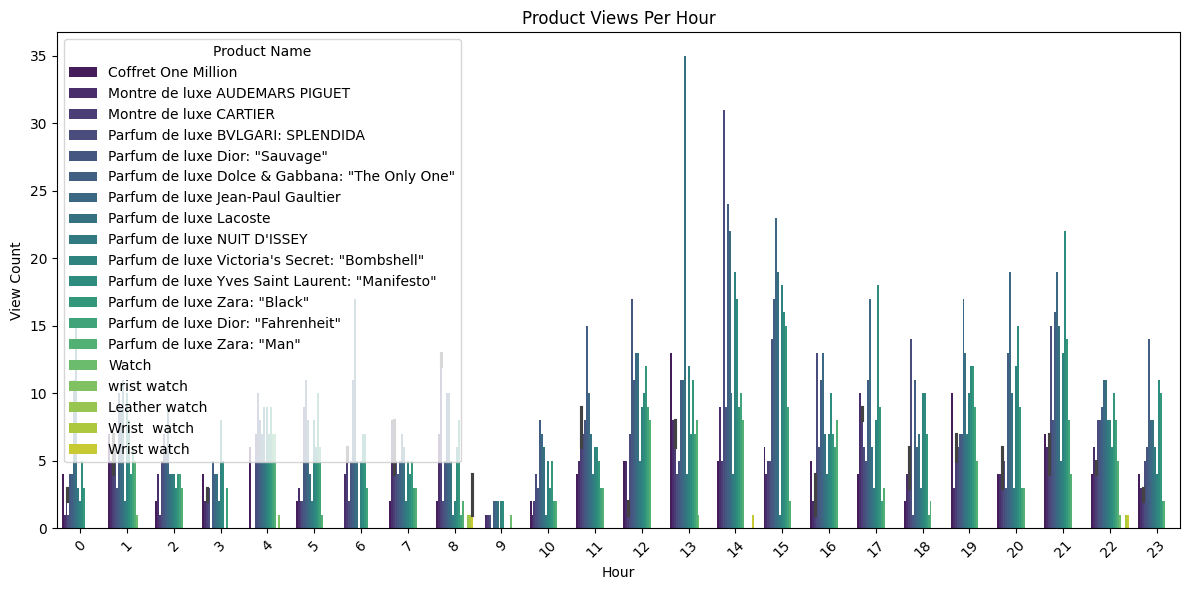

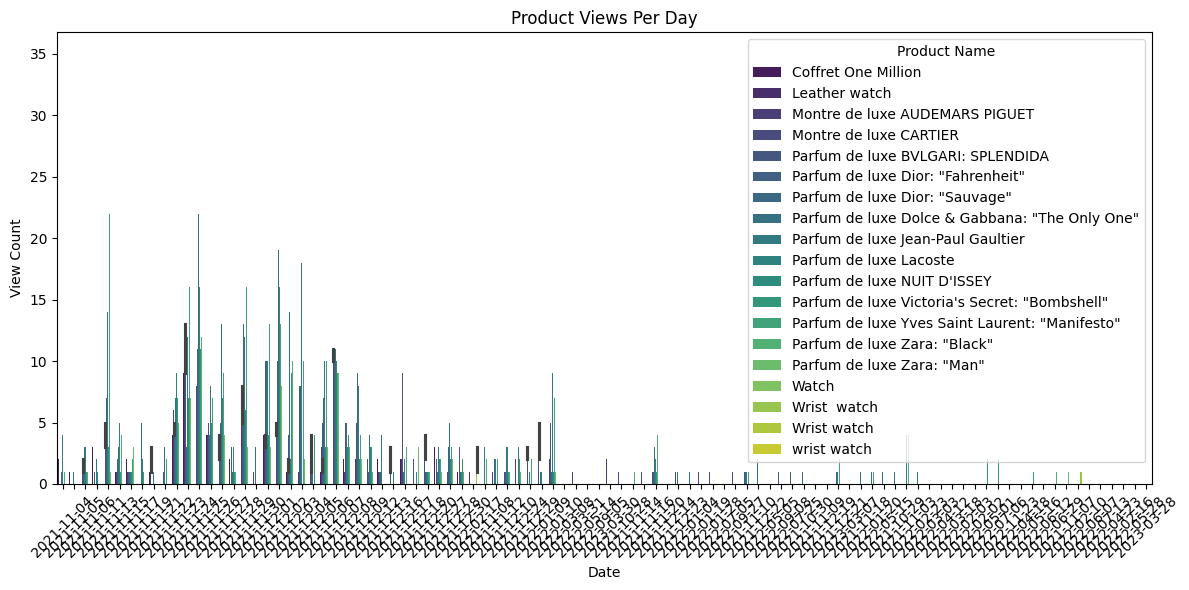

In [26]:
# Example usage
vendor_id = 268  # Replace with the actual vendor ID
df_hourly, df_daily = get_views_frequency(vendor_id)
if df_hourly is not None and df_daily is not None:
    plot_views_frequency(df_hourly, df_daily)

In [27]:
df_hourly

,product_name,view_hour,view_count_per_hour
0,Coffret One Million,0,4
1,Coffret One Million,1,7
2,Coffret One Million,2,2
3,Coffret One Million,3,4
4,Coffret One Million,4,6
...,...,...,...
349,wrist watch,4,1
350,Wrist watch,8,4
351,Wrist watch,8,1
352,Wrist watch,14,1


In [47]:
def cohort_analysis(vendor_id):
    db_connector = DatabaseConnector()
    db_connector.connect_db()
    connection = db_connector.get_connection()

    if connection is None:
        print("No connection available for cohort analysis.")
        return None

    try:
        # Query to get the cohort data
        query = """
        WITH first_views AS (
            SELECT 
                p.user_id,
                MIN(DATE_FORMAT(pvl.created_at, '%Y-%m')) AS cohort_month
            FROM 
                product_view_logs pvl
            JOIN 
                products p ON p.id = pvl.product_id
            WHERE 
                p.user_id = %s
            GROUP BY 
                p.user_id
        ),
        cohort_views AS (
            SELECT
                fv.cohort_month,
                DATE_FORMAT(pvl.created_at, '%Y-%m') AS view_month,
                COUNT(pvl.id) AS views_count
            FROM 
                product_view_logs pvl
            JOIN 
                products p ON p.id = pvl.product_id
            JOIN 
                first_views fv ON fv.user_id = p.user_id
            WHERE 
                p.user_id = %s
            GROUP BY 
                fv.cohort_month, view_month
        )
        SELECT 
            cohort_month,
            view_month,
            SUM(views_count) AS views_count
        FROM 
            cohort_views
        GROUP BY 
            cohort_month, view_month
        ORDER BY 
            cohort_month, view_month
        """
        
        # Execute the query using pd.read_sql_query
        df = pd.read_sql_query(query, connection, params=(vendor_id, vendor_id))
        
        return df
    except Error as e:
        print(f"Error: {e}")
        return None
    finally:
        db_connector.close_connection()

def plot_cohort_analysis(df):
    # Pivot the dataframe to prepare for plotting
    df_pivot = df.pivot(index='cohort_month', columns='view_month', values='views_count')

    # Calculate total views for each cohort month
    df_pivot['Total'] = df_pivot.sum(axis=1)

    # Find the maximum value to highlight in the plot
    max_value = df_pivot.drop('Total', axis=1).max().max()

    # Plotting
    plt.figure(figsize=(12, 8))

    # Heatmap with annotations and color bar
    sns.heatmap(df_pivot.drop('Total', axis=1), annot=True, fmt='.0f', cmap='Blues', cbar=True, linewidths=0.5)

    # Highlight maximum value with a different color
    for i in range(len(df_pivot.index)):
        for j in range(len(df_pivot.columns)-1):
            if df_pivot.iloc[i, j] == max_value:
                plt.text(j + 0.5, i + 0.5, df_pivot.iloc[i, j], ha='center', va='center', color='red', fontsize=10, fontweight='bold')

    # Total views annotations
    for i in range(len(df_pivot.index)):
        plt.text(len(df_pivot.columns) - 0.5, i + 0.5, df_pivot.iloc[i, -1], ha='center', va='center', color='black', fontsize=10)

    plt.title('Cohort Analysis of Product Views')
    plt.xlabel('View Month')
    plt.ylabel('Cohort Month')
    plt.tight_layout()
    plt.show()

Successfully connected to the database


/tmp/ipykernel_39950/3109036470.py:55: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection, params=(vendor_id, vendor_id))


Connection closed


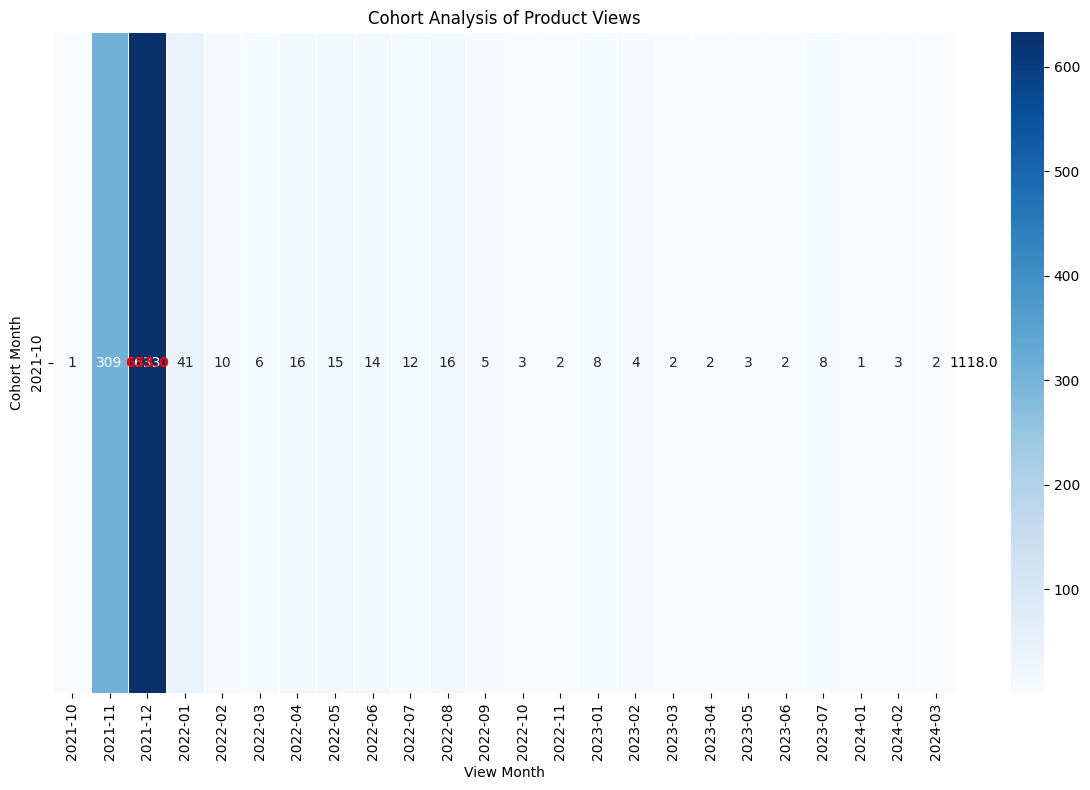

In [48]:
# Example usage
vendor_id = 266  # Replace with the actual vendor ID
df_cohort = cohort_analysis(vendor_id)
if df_cohort is not None:
    plot_cohort_analysis(df_cohort)

In [49]:
def plot_cohort_analysis(df):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Pivot the dataframe to prepare for plotting
    df_pivot = df.pivot(index='view_month', columns='cohort_month', values='views_count')

    # Plotting
    plt.figure(figsize=(12, 8))

    # Plot each cohort as a separate line
    for cohort_month in df_pivot.columns:
        plt.plot(df_pivot.index, df_pivot[cohort_month], marker='o', label=f'Cohort {cohort_month}')

    # Highlight maximum values with annotations
    max_values = df_pivot.max()
    for idx, max_val in max_values.items():
        plt.text(idx, max_val, f'{int(max_val)}', ha='right', va='bottom', fontsize=10)

    # Add labels and title
    plt.title('Cohort Analysis of Product Views Over Time')
    plt.xlabel('View Month')
    plt.ylabel('Number of Views')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Successfully connected to the database


/tmp/ipykernel_39950/3109036470.py:55: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection, params=(vendor_id, vendor_id))


Connection closed


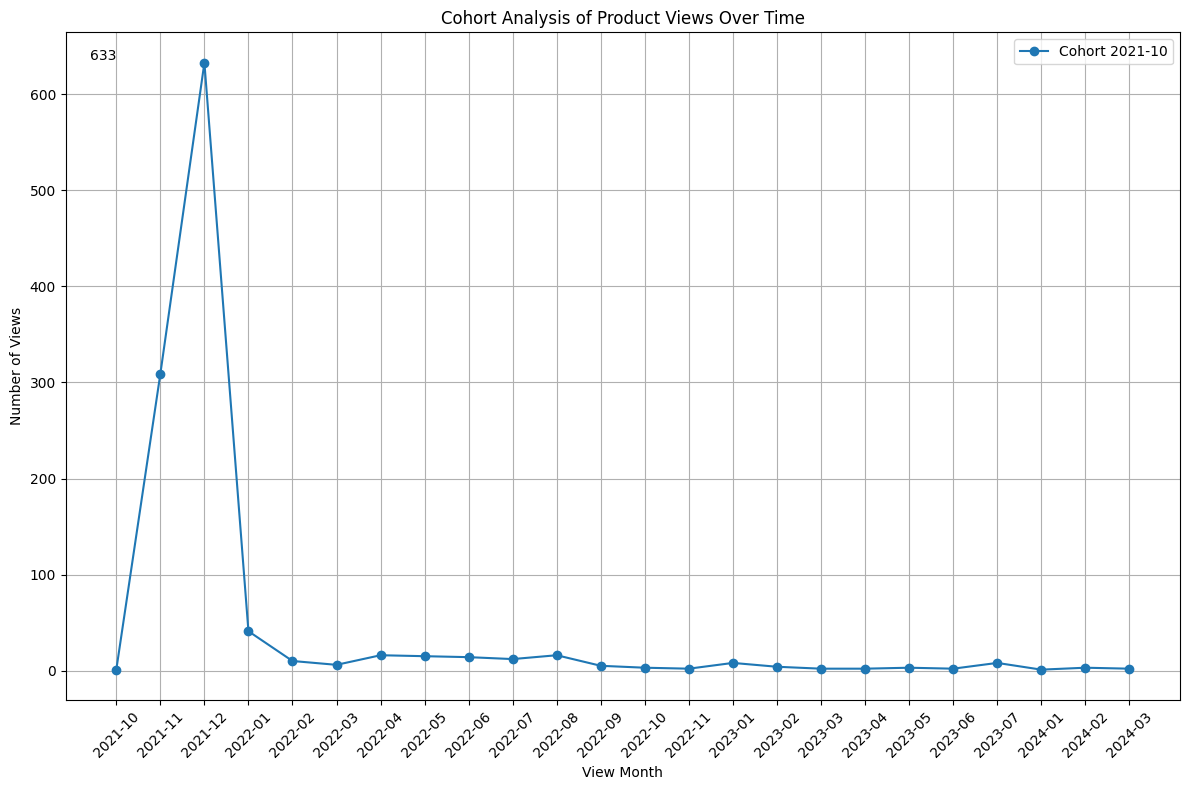

In [50]:

# Example usage
vendor_id = 266  # Replace with the actual vendor ID
df_cohort = cohort_analysis(vendor_id)
if df_cohort is not None:
    plot_cohort_analysis(df_cohort)

In [51]:
def plot_cohort_analysis(df):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Pivot the dataframe to prepare for plotting
    df_pivot = df.pivot(index='view_month', columns='cohort_month', values='views_count')

    # Plotting
    plt.figure(figsize=(12, 8))

    # Plot each cohort as a separate line
    for cohort_month in df_pivot.columns:
        plt.plot(df_pivot.index, df_pivot[cohort_month], marker='o', label=f'Cohort {cohort_month}')

    # Highlight maximum values with annotations
    max_values = df_pivot.max()
    for idx, max_val in max_values.items():
        plt.text(idx, max_val, f'{int(max_val)}', ha='right', va='bottom', fontsize=10)

    # Annotate key points
    key_points = {
        'Peak Engagement': ('2023-03', 200),  # Example of peak engagement month
        'Stable Growth': ('2023-06', 150),   # Example of stable growth
        'Drop in Views': ('2023-09', 100)    # Example of a drop in views
    }
    for label, (month, value) in key_points.items():
        plt.annotate(label, xy=(month, value), xytext=(month, value + 20),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=10, ha='center')

    # Add labels and title
    plt.title('Cohort Analysis of Product Views Over Time')
    plt.xlabel('View Month')
    plt.ylabel('Number of Views')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Successfully connected to the database


/tmp/ipykernel_39950/3109036470.py:55: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection, params=(vendor_id, vendor_id))


Connection closed


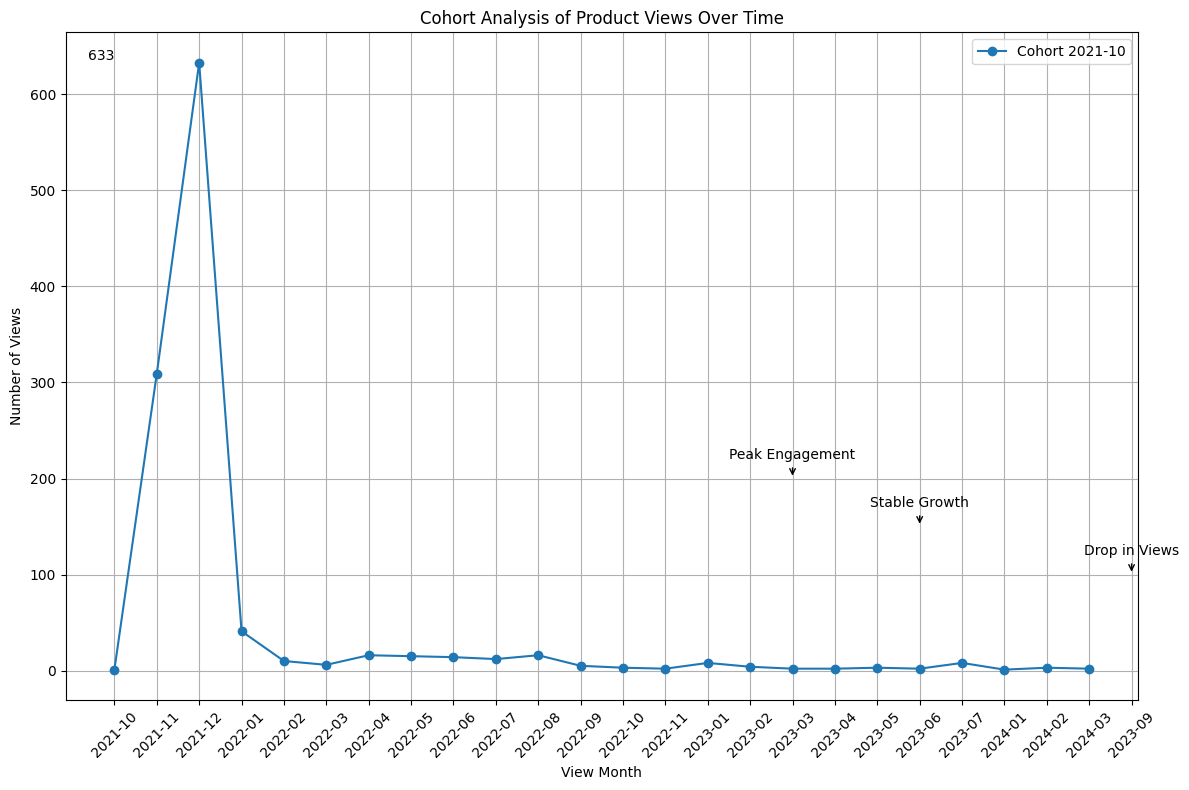

In [52]:
# Example usage
vendor_id = 266  # Replace with the actual vendor ID
df_cohort = cohort_analysis(vendor_id)
if df_cohort is not None:
    plot_cohort_analysis(df_cohort)